# RL Training

This notebook trains the RL agent on the corpus words.

**Note for M1 Pro MacBook:** 
- Training 5000 episodes should take approximately 15-30 minutes
- Consider reducing `num_episodes` to 2000-3000 for faster iteration
- The training uses CPU, so it's well-suited for your M1 Pro

The training loop:
1. Sample a word from corpus
2. Create environment for that word
3. Agent interacts with environment using HMM-guided actions
4. Update Q-values based on rewards
5. Track metrics (win rate, rewards, wrong guesses)


In [1]:
import sys
sys.path.append('../src')

import numpy as np
import random
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
from collections import defaultdict

from rl_agent import QLearningAgent
from hmm_model import HangmanHMM
from hangman_env import HangmanEnv
from utils import encode_state

# Load HMM model
hmm = HangmanHMM()
hmm.load('../models/hmm_model.pkl')
print("HMM model loaded")

# Load corpus words
with open('../results/preprocessed_data.pkl', 'rb') as f:
    preprocessed_data = pickle.load(f)

corpus_words = preprocessed_data['words']
print(f"Loaded {len(corpus_words)} words from corpus")


Model loaded from ../models/hmm_model.pkl
HMM model loaded
Loaded 50000 words from corpus


In [2]:
# Initialize RL agent
agent = QLearningAgent(
    learning_rate=0.1,
    discount_factor=0.95,
    epsilon=1.0,  # Start with full exploration
    epsilon_decay=0.9995,  # Slow decay for more exploration
    epsilon_min=0.05,
    max_word_length=30
)

print("RL agent initialized")
print(f"Initial epsilon: {agent.epsilon}")
print(f"Epsilon decay: {agent.epsilon_decay}")
print(f"Min epsilon: {agent.epsilon_min}")


RL agent initialized
Initial epsilon: 1.0
Epsilon decay: 0.9995
Min epsilon: 0.05


In [3]:
# Training hyperparameters
# For M1 Pro: Start with 3000 episodes for faster training, increase to 5000 if time permits
num_episodes = 3000  # Reduced from 5000 for faster training on M1 Pro
eval_interval = 500  # Evaluate every N episodes
eval_episodes = 100  # Number of episodes for evaluation

# Training statistics
training_history = {
    'episode_rewards': [],
    'episode_wins': [],
    'episode_wrong_guesses': [],
    'episode_repeated_guesses': [],
    'epsilon_values': [],
    'eval_win_rates': [],
    'eval_avg_rewards': [],
    'eval_wrong_guesses': []
}


In [4]:
def train_episode(agent, hmm, word):
    """Train agent on a single episode."""
    env = HangmanEnv(word, max_lives=6)
    state = env.reset()
    
    episode_reward = 0.0
    episode_wrong = 0
    episode_repeated = 0
    
    prev_state_features = None
    prev_hmm_probs = None
    prev_action = None
    prev_reward = 0.0
    prev_guessed = None
    
    while not env.done:
        # Get current state
        masked_list = env.get_masked_word_list()
        hmm_probs = hmm.predict_letter_probabilities(masked_list, env.guessed_letters, len(word))
        state_features = encode_state(masked_list, env.guessed_letters, hmm_probs,
                                     env.lives, len(word))
        
        # Select action
        action = agent.select_action(state_features, hmm_probs, env.guessed_letters)
        
        # Take step
        next_state, reward, done, info = env.step(action)
        episode_reward += reward
        
        # Track statistics
        if info.get('repeated', False):
            episode_repeated += 1
        elif not info.get('correct', False) and not info.get('repeated', False):
            episode_wrong += 1
        
        # Update Q-value if we have previous state
        if prev_state_features is not None:
            agent.update_q_value(
                prev_state_features,
                prev_action,
                prev_reward,
                state_features,
                hmm_probs,
                env.guessed_letters,
                done,
                current_hmm_probs=prev_hmm_probs
            )
        
        # Update previous state
        prev_state_features = state_features
        prev_hmm_probs = hmm_probs
        prev_action = action
        prev_reward = reward
        prev_guessed = env.guessed_letters.copy()
        
        if done:
            # Final update
            agent.update_q_value(
                prev_state_features,
                prev_action,
                prev_reward,
                None,
                None,
                None,
                done,
                current_hmm_probs=prev_hmm_probs
            )
            break
    
    won = env.won
    stats = env.get_stats()
    
    return {
        'reward': episode_reward,
        'won': won,
        'wrong_guesses': stats['wrong_count'],
        'repeated_guesses': stats['repeated_count']
    }

print("Training function defined")


Training function defined


In [5]:
def evaluate_agent(agent, hmm, words, num_episodes=100):
    """Evaluate agent on a set of words."""
    wins = 0
    total_reward = 0.0
    total_wrong = 0
    total_repeated = 0
    
    # Temporarily set epsilon to 0 for evaluation (pure exploitation)
    original_epsilon = agent.epsilon
    agent.epsilon = 0.0
    
    eval_words = random.sample(words, min(num_episodes, len(words)))
    
    for word in eval_words:
        result = train_episode(agent, hmm, word)
        if result['won']:
            wins += 1
        total_reward += result['reward']
        total_wrong += result['wrong_guesses']
        total_repeated += result['repeated_guesses']
    
    # Restore epsilon
    agent.epsilon = original_epsilon
    
    return {
        'win_rate': wins / len(eval_words),
        'avg_reward': total_reward / len(eval_words),
        'avg_wrong': total_wrong / len(eval_words),
        'avg_repeated': total_repeated / len(eval_words)
    }

print("Evaluation function defined")


Evaluation function defined


In [6]:
# Training loop
print("=" * 60)
print("STARTING TRAINING")
print("=" * 60)
print(f"Training episodes: {num_episodes}")
print(f"Evaluation interval: {eval_interval} episodes")
print(f"Evaluation episodes: {eval_episodes}")
print("Note: On M1 Pro, this should take ~15-30 minutes")
print()

# Set random seed for reproducibility
random.seed(42)
np.random.seed(42)

for episode in tqdm(range(num_episodes)):
    # Sample random word from corpus
    word = random.choice(corpus_words)
    
    # Train on episode
    result = train_episode(agent, hmm, word)
    
    # Record statistics
    training_history['episode_rewards'].append(result['reward'])
    training_history['episode_wins'].append(1 if result['won'] else 0)
    training_history['episode_wrong_guesses'].append(result['wrong_guesses'])
    training_history['episode_repeated_guesses'].append(result['repeated_guesses'])
    training_history['epsilon_values'].append(agent.get_epsilon())
    
    # Decay epsilon
    agent.decay_epsilon()
    
    # Periodic evaluation
    if (episode + 1) % eval_interval == 0:
        eval_results = evaluate_agent(agent, hmm, corpus_words, eval_episodes)
        training_history['eval_win_rates'].append(eval_results['win_rate'])
        training_history['eval_avg_rewards'].append(eval_results['avg_reward'])
        training_history['eval_wrong_guesses'].append(eval_results['avg_wrong'])
        
        print(f"\nEpisode {episode + 1}:")
        print(f"  Epsilon: {agent.get_epsilon():.4f}")
        print(f"  Eval Win Rate: {eval_results['win_rate']:.4f}")
        print(f"  Eval Avg Reward: {eval_results['avg_reward']:.2f}")
        print(f"  Eval Avg Wrong Guesses: {eval_results['avg_wrong']:.2f}")
        print(f"  Q-table size: {len(agent.q_table)} entries")

print("\nTraining completed!")


STARTING TRAINING
Training episodes: 3000
Evaluation interval: 500 episodes
Evaluation episodes: 100
Note: On M1 Pro, this should take ~15-30 minutes



 22%|██▏       | 668/3000 [00:00<00:02, 853.37it/s] 


Episode 500:
  Epsilon: 0.7788
  Eval Win Rate: 0.1700
  Eval Avg Reward: 1.07
  Eval Avg Wrong Guesses: 5.57
  Q-table size: 3724 entries


 42%|████▏     | 1265/3000 [00:01<00:02, 849.50it/s]


Episode 1000:
  Epsilon: 0.6065
  Eval Win Rate: 0.1600
  Eval Avg Reward: -0.13
  Eval Avg Wrong Guesses: 5.70
  Q-table size: 7313 entries


 55%|█████▍    | 1641/3000 [00:02<00:01, 738.57it/s]


Episode 1500:
  Epsilon: 0.4723
  Eval Win Rate: 0.2400
  Eval Avg Reward: 2.31
  Eval Avg Wrong Guesses: 5.56
  Q-table size: 10988 entries


 73%|███████▎  | 2191/3000 [00:02<00:01, 767.67it/s]


Episode 2000:
  Epsilon: 0.3678
  Eval Win Rate: 0.2200
  Eval Avg Reward: 2.75
  Eval Avg Wrong Guesses: 5.44
  Q-table size: 14939 entries


 89%|████████▊ | 2662/3000 [00:03<00:00, 743.71it/s]


Episode 2500:
  Epsilon: 0.2864
  Eval Win Rate: 0.2100
  Eval Avg Reward: 1.46
  Eval Avg Wrong Guesses: 5.55
  Q-table size: 18818 entries


100%|██████████| 3000/3000 [00:03<00:00, 781.38it/s]


Episode 3000:
  Epsilon: 0.2230
  Eval Win Rate: 0.2000
  Eval Avg Reward: 1.09
  Eval Avg Wrong Guesses: 5.60
  Q-table size: 22644 entries

Training completed!


In [7]:
# Save trained agent
import os
os.makedirs('../models', exist_ok=True)
agent.save('../models/rl_agent.pkl')
print("✓ Trained agent saved")

# Save training history
with open('../results/training_history.pkl', 'wb') as f:
    pickle.dump(training_history, f)
print("✓ Training history saved")


Agent saved to ../models/rl_agent.pkl
✓ Trained agent saved
✓ Training history saved


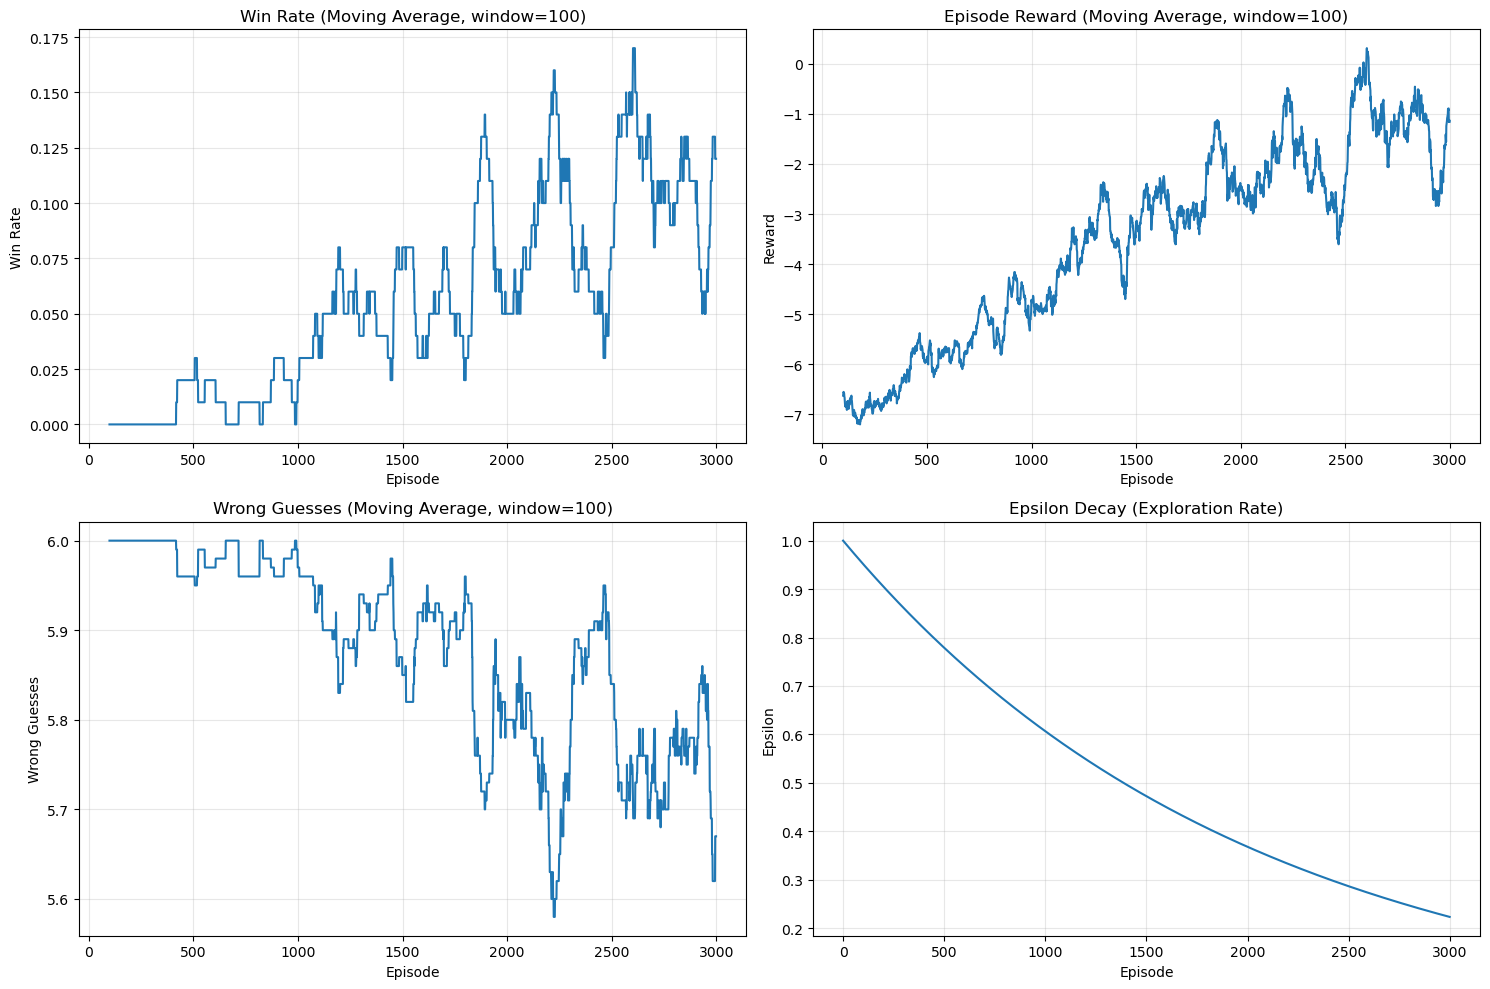

In [8]:
# Visualize training progress
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Win rate over episodes (moving average)
window = 100
if len(training_history['episode_wins']) >= window:
    wins_array = np.array(training_history['episode_wins'])
    moving_avg_wins = np.convolve(wins_array, np.ones(window)/window, mode='valid')
    axes[0, 0].plot(range(window-1, len(wins_array)), moving_avg_wins)
    axes[0, 0].set_title(f'Win Rate (Moving Average, window={window})')
    axes[0, 0].set_xlabel('Episode')
    axes[0, 0].set_ylabel('Win Rate')
    axes[0, 0].grid(True, alpha=0.3)

# Reward over episodes (moving average)
rewards_array = np.array(training_history['episode_rewards'])
moving_avg_rewards = np.convolve(rewards_array, np.ones(window)/window, mode='valid')
axes[0, 1].plot(range(window-1, len(rewards_array)), moving_avg_rewards)
axes[0, 1].set_title(f'Episode Reward (Moving Average, window={window})')
axes[0, 1].set_xlabel('Episode')
axes[0, 1].set_ylabel('Reward')
axes[0, 1].grid(True, alpha=0.3)

# Wrong guesses over episodes (moving average)
wrong_array = np.array(training_history['episode_wrong_guesses'])
moving_avg_wrong = np.convolve(wrong_array, np.ones(window)/window, mode='valid')
axes[1, 0].plot(range(window-1, len(wrong_array)), moving_avg_wrong)
axes[1, 0].set_title(f'Wrong Guesses (Moving Average, window={window})')
axes[1, 0].set_xlabel('Episode')
axes[1, 0].set_ylabel('Wrong Guesses')
axes[1, 0].grid(True, alpha=0.3)

# Epsilon decay
axes[1, 1].plot(training_history['epsilon_values'])
axes[1, 1].set_title('Epsilon Decay (Exploration Rate)')
axes[1, 1].set_xlabel('Episode')
axes[1, 1].set_ylabel('Epsilon')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.savefig('../results/training_progress.png', dpi=150, bbox_inches='tight')
plt.show()


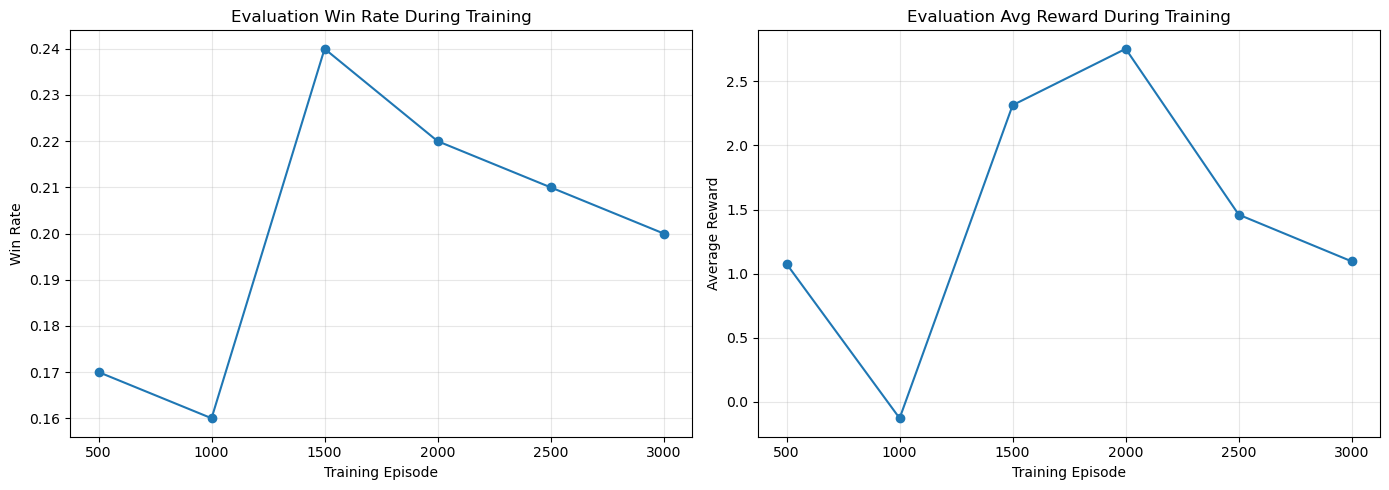


✓ Training visualization complete


In [9]:
# Evaluation results over training
if training_history['eval_win_rates']:
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))
    
    eval_episodes = [eval_interval * (i+1) for i in range(len(training_history['eval_win_rates']))]
    
    axes[0].plot(eval_episodes, training_history['eval_win_rates'], marker='o')
    axes[0].set_title('Evaluation Win Rate During Training')
    axes[0].set_xlabel('Training Episode')
    axes[0].set_ylabel('Win Rate')
    axes[0].grid(True, alpha=0.3)
    
    axes[1].plot(eval_episodes, training_history['eval_avg_rewards'], marker='o')
    axes[1].set_title('Evaluation Avg Reward During Training')
    axes[1].set_xlabel('Training Episode')
    axes[1].set_ylabel('Average Reward')
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.savefig('../results/evaluation_progress.png', dpi=150, bbox_inches='tight')
    plt.show()

print("\n✓ Training visualization complete")
